In [7]:
import numpy as np
import matplotlib.pyplot as plt
import filters

In [8]:
def dB20(x):
    return 20*np.log(np.abs(x))

C:\Users\pelad\AppData\Local\Temp\ipykernel_13256\2813961451.py:2: RuntimeWarning: divide by zero encountered in log
  return 20*np.log(np.abs(x))


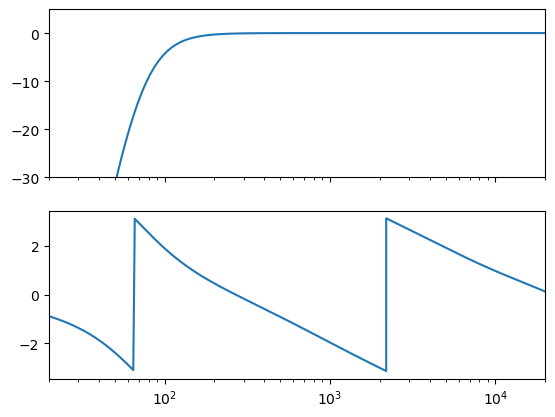

In [13]:
sr = 44100
n_fft = 8192*4
Q=.71


f = np.fft.rfftfreq(n=n_fft, d=1/sr)

apf = filters.equalizer.RBJ.AllPass(f0=3000, Q=Q, sr=sr)

hpf = filters.LR.HP4(f0=70, sr=sr)

loudspeaker = filters.Filters_Series(apf, hpf, sr=sr)


fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(f, dB20(loudspeaker.get_rfft(n=n_fft)))
ax[0].set_ylim(-30, 5)
ax[1].plot(f, np.angle(loudspeaker.get_rfft(n=n_fft)))
ax[0].set_xlim(20, 20000)
plt.semilogx()
plt.show()

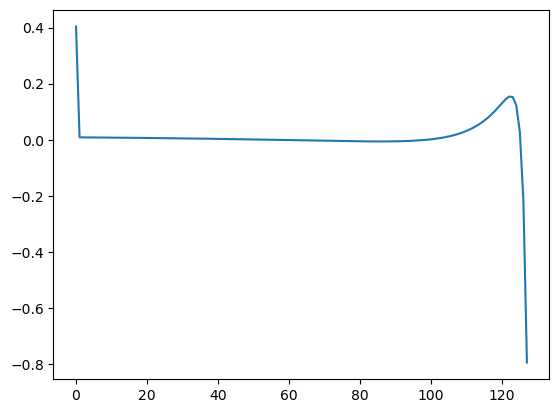

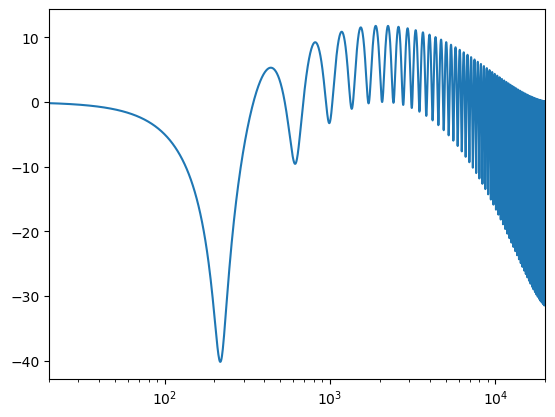

In [29]:
n=128

corr = np.ones(n//2+1, dtype=np.complex128)

corr = corr*np.exp(-1j*np.angle(loudspeaker.get_rfft(n=n)))
corr_IR = np.fft.irfft(corr)

plt.plot(corr_IR)
plt.show()
plt.plot(f, dB20(np.fft.rfft(corr_IR, n=n_fft)))
plt.semilogx()
plt.xlim(20, 20000)
plt.show()